<a href="https://colab.research.google.com/github/Larraguibel/DNN_neuroscience/blob/main/blurring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importaciones

In [1]:
cuda = True
train_batch_size = 32
test_batch_size = 124
best_loss = float("inf")
best_epoch = -1
dataset_path = './cifar10'
gsync_save = True

In [2]:
from torchvision import transforms, datasets
import torch
import matplotlib.pyplot as plt
from google.colab import drive

In [3]:
try:
    import torch
except ModuleNotFoundError:
    from os import path
    from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
    platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

    accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

    !pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.1-{platform}-linux_x86_64.whl
    import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable


try:
    import torchvision
except ModuleNotFoundError:
    !pip install -q torchvision

from torchvision import datasets, transforms


if gsync_save:
    try:
        import utils
    except ModuleNotFoundError:
        !wget https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
        import utils

    gsync = utils.GDriveSync()


try:
    from allconv import AllConvNet
except ModuleNotFoundError:
    !wget https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
    from allconv import AllConvNet

--2023-11-11 20:37:23--  https://raw.githubusercontent.com/StefOe/colab-pytorch-utils/HEAD/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4519 (4.4K) [text/plain]
Saving to: ‘utils.py’

utils.py            100%[===================>]   4.41K  --.-KB/s    in 0s      

2023-11-11 20:37:23 (56.4 MB/s) - ‘utils.py’ saved [4519/4519]

--2023-11-11 20:37:51--  https://github.com/StefOe/all-conv-pytorch/raw/HEAD/allconv.py
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/StefOe/all-conv-pytorch/8545bb3ff7ac4410e52d8db930f0485074073ea9/allconv.py [following]
--2023-11-11 20:37:51--  https://raw.

## 2. Transformacion y carga de datos

In [4]:
# Semilla para estandarizar resultados
torch.manual_seed(2320)

cuda = cuda and torch.cuda.is_available()

trainset = datasets.CIFAR10(root=dataset_path, train=True, download=True)
train_mean = trainset.data.mean(axis=(0, 1, 2)) / 255
train_std = trainset.data.std(axis=(0, 1, 2)) / 255


# Data normal (32x32)

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


#  transformaciones a 8x8 y de vuelta a 32x32 por bilineal

transform_train8x8 = transforms.Compose([
    transforms.Resize((8,8)),
    transforms.Resize((32,32)),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(train_mean, train_std)
])


100%|██████████| 170498071/170498071 [00:03<00:00, 44138326.85it/s]


Extracting ./cifar10/cifar-10-python.tar.gz to ./cifar10


In [5]:
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}

# Data normal

train_loader = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train),
    batch_size=train_batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root=dataset_path, train=False, download=True,
    transform=transform_test),
    batch_size=test_batch_size, shuffle=True, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
# Data de entrenamiento blurreada

train_loader_blur = torch.utils.data.DataLoader(datasets.CIFAR10(
    root=dataset_path, train=True, download=True,
    transform=transform_train8x8),
    batch_size=train_batch_size, shuffle=True, **kwargs)


Files already downloaded and verified


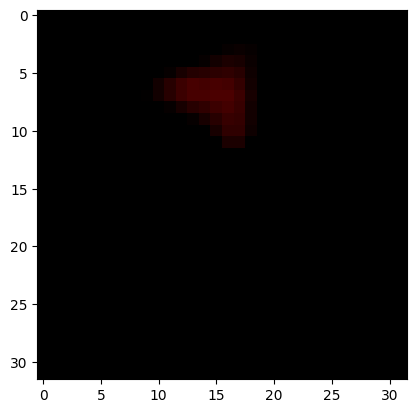

In [7]:
for batch_data, batch_labels in train_loader_blur:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

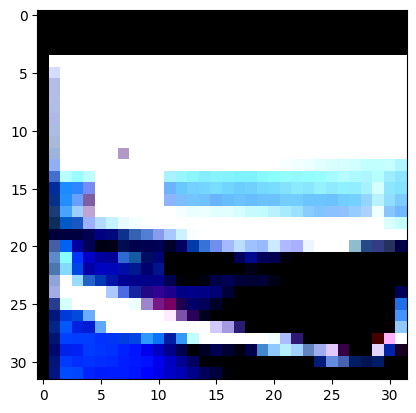

In [8]:
for batch_data, batch_labels in train_loader:
    first_image = batch_data[0].permute(1, 2, 0).numpy()
    plt.imshow(first_image)
    plt.show()
    break

## 3. Entrenamiento

In [9]:
model = AllConvNet(3)
if cuda:
    model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(
    optimizer, milestones=[200, 250, 300], gamma=0.1)

In [10]:
def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def blur_train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader_blur):
        if cuda:
            data, target = data.cuda(), target.cuda() # Pasar la data a la GPU
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad() # Seteo en 0 los valores de los gradientes
        output = model(data) # Hago forward
        loss = criterion(output, target) # Se calcula la CrossEntropyLoss
        loss.backward()
        optimizer.step() # Actualización de los parámetros

        if batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))


def test(epoch, best_loss, best_epoch):
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        output = model(data)
        # sum up batch loss
        test_loss += criterion(output, target).item()
        # get the index of the max log-probability
        pred = output.data.max(1, keepdim=True)[1]
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    test_loss /= len(test_loader.dataset)
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset), 100. * correct /
            len(test_loader.dataset)))

    if test_loss < best_loss:
        best_epoch = epoch
        best_loss = test_loss
        torch.save(model, "best.pt")
        if gsync_save:
            gsync.update_file_to_folder("best.pt")
    return best_loss, best_epoch

Esta primera version del codigo,  entrena:

*   normalmente para `normal_init` epocas
*   con blur para `blur_epochs` epocas
*   normalmente para otras `after_blur` epocas.

In [11]:
def begin_model_easy(normal_init: int, blur_epochs: int, after_blur: int):
  best_loss = float("inf")
  best_epoch = -1

  if normal_init<0 or blur_epochs<0 or after_blur<0:
    print('ERROR: parámetros inconsistentes')
  else:
    if normal_init == 0:

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(blur_epochs, blur_epochs + after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)


    elif normal_init != 0:

      print(f''' {'*'*30}
      Normal training begin
                 {'*'*30}
      ''')
      for epoch in range(normal_init):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training begin
                 {'*'*30}
      ''')

      for epoch in range(normal_init, normal_init + blur_epochs):
        scheduler.step()
        blur_train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

      print(f''' {'*'*30}
      Blurred image Training End. Training with normal images
                 {'*'*30}
      ''')

      for epoch in range(normal_init+blur_epochs, normal_init+blur_epochs+after_blur):
        scheduler.step()
        train(epoch)
        best_loss, best_epoch = test(epoch, best_loss, best_epoch)

# Experimento 1 de Achille et al.

Vamos a entrenar con blur por $t_0$ epocas, con $t_0\in \{0, 20, 40, ... , 140\}$ y sucesivamente entrenamos por $160$ epocas sin blur.

Para ahorrar calculos,
* primero entrenamos modelo con blur por $140$ epocas y con un checkpoint cada $20$ epocas,
* sucesivamente entrenamos desde cada checkpoint por $160$ epocas sin blur, (se podra' hacer en paralelo?).



In [12]:
def checkpoints(epoch: int, save_every=20):
    if (epoch + 1) % save_every == 0:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }

        checkpoint_path = f'/content/gdrive/MyDrive/Colab Notebooks/checkpoints1/checkpoint_epoch_{epoch}.pt'
        torch.save(checkpoint, checkpoint_path)
        print(f'\nCheckpoint saved at epoch {epoch + 1}.\ ')

In [ ]:
# Damos acceso a google drive para guardar modelos

drive.mount('/content/gdrive')

In [15]:
# Entrenamos red nomral (sin blur) por 140 épocas y guardamos cada 20

for epoch in range(160):
    scheduler.step()
    train(epoch)
    best_loss, best_epoch = test(epoch, best_loss, best_epoch)
    checkpoints(epoch)

Train Epoch: 0 [0/50000 (0%)]	Loss: 1.861263
Train Epoch: 0 [3200/50000 (6%)]	Loss: 1.796791
Train Epoch: 0 [6400/50000 (13%)]	Loss: 1.703753
Train Epoch: 0 [9600/50000 (19%)]	Loss: 1.710199
Train Epoch: 0 [12800/50000 (26%)]	Loss: 1.752579
Train Epoch: 0 [16000/50000 (32%)]	Loss: 1.824962
Train Epoch: 0 [19200/50000 (38%)]	Loss: 1.788869
Train Epoch: 0 [22400/50000 (45%)]	Loss: 1.933407
Train Epoch: 0 [25600/50000 (51%)]	Loss: 1.841643
Train Epoch: 0 [28800/50000 (58%)]	Loss: 1.770468
Train Epoch: 0 [32000/50000 (64%)]	Loss: 1.733823
Train Epoch: 0 [35200/50000 (70%)]	Loss: 1.715431
Train Epoch: 0 [38400/50000 (77%)]	Loss: 1.971622
Train Epoch: 0 [41600/50000 (83%)]	Loss: 1.898782
Train Epoch: 0 [44800/50000 (90%)]	Loss: 1.691431
Train Epoch: 0 [48000/50000 (96%)]	Loss: 1.783386

Test set: Average loss: 0.0144, Accuracy: 3430/10000 (34%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 73.09it/s]


Train Epoch: 1 [0/50000 (0%)]	Loss: 1.829693
Train Epoch: 1 [3200/50000 (6%)]	Loss: 1.682774
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.932510
Train Epoch: 1 [9600/50000 (19%)]	Loss: 1.778202
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.868462
Train Epoch: 1 [16000/50000 (32%)]	Loss: 1.778747
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.907798
Train Epoch: 1 [22400/50000 (45%)]	Loss: 1.695428
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.738316
Train Epoch: 1 [28800/50000 (58%)]	Loss: 1.690436
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.564013
Train Epoch: 1 [35200/50000 (70%)]	Loss: 1.665633
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.963771
Train Epoch: 1 [41600/50000 (83%)]	Loss: 1.771425
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.765624
Train Epoch: 1 [48000/50000 (96%)]	Loss: 1.752807

Test set: Average loss: 0.0142, Accuracy: 3494/10000 (35%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 80.18it/s]


Train Epoch: 2 [0/50000 (0%)]	Loss: 1.498737
Train Epoch: 2 [3200/50000 (6%)]	Loss: 1.513379
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.690777
Train Epoch: 2 [9600/50000 (19%)]	Loss: 1.578190
Train Epoch: 2 [12800/50000 (26%)]	Loss: 1.657937
Train Epoch: 2 [16000/50000 (32%)]	Loss: 1.729145
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.697209
Train Epoch: 2 [22400/50000 (45%)]	Loss: 1.664089
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.727266
Train Epoch: 2 [28800/50000 (58%)]	Loss: 1.494360
Train Epoch: 2 [32000/50000 (64%)]	Loss: 2.024439
Train Epoch: 2 [35200/50000 (70%)]	Loss: 1.703659
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.691496
Train Epoch: 2 [41600/50000 (83%)]	Loss: 1.734539
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.940928
Train Epoch: 2 [48000/50000 (96%)]	Loss: 1.900335

Test set: Average loss: 0.0139, Accuracy: 3727/10000 (37%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.47it/s]


Train Epoch: 3 [0/50000 (0%)]	Loss: 1.655013
Train Epoch: 3 [3200/50000 (6%)]	Loss: 1.703445
Train Epoch: 3 [6400/50000 (13%)]	Loss: 1.624487
Train Epoch: 3 [9600/50000 (19%)]	Loss: 1.789581
Train Epoch: 3 [12800/50000 (26%)]	Loss: 1.697382
Train Epoch: 3 [16000/50000 (32%)]	Loss: 1.557499
Train Epoch: 3 [19200/50000 (38%)]	Loss: 2.064171
Train Epoch: 3 [22400/50000 (45%)]	Loss: 1.648923
Train Epoch: 3 [25600/50000 (51%)]	Loss: 1.551912
Train Epoch: 3 [28800/50000 (58%)]	Loss: 1.819203
Train Epoch: 3 [32000/50000 (64%)]	Loss: 1.632013
Train Epoch: 3 [35200/50000 (70%)]	Loss: 1.605134
Train Epoch: 3 [38400/50000 (77%)]	Loss: 1.748591
Train Epoch: 3 [41600/50000 (83%)]	Loss: 1.554807
Train Epoch: 3 [44800/50000 (90%)]	Loss: 1.748988
Train Epoch: 3 [48000/50000 (96%)]	Loss: 1.533098

Test set: Average loss: 0.0138, Accuracy: 3776/10000 (38%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 75.26it/s]


Train Epoch: 4 [0/50000 (0%)]	Loss: 1.790779
Train Epoch: 4 [3200/50000 (6%)]	Loss: 1.663038
Train Epoch: 4 [6400/50000 (13%)]	Loss: 1.960373
Train Epoch: 4 [9600/50000 (19%)]	Loss: 1.799431
Train Epoch: 4 [12800/50000 (26%)]	Loss: 1.674656
Train Epoch: 4 [16000/50000 (32%)]	Loss: 1.869327
Train Epoch: 4 [19200/50000 (38%)]	Loss: 1.501157
Train Epoch: 4 [22400/50000 (45%)]	Loss: 1.849513
Train Epoch: 4 [25600/50000 (51%)]	Loss: 1.866563
Train Epoch: 4 [28800/50000 (58%)]	Loss: 1.852592
Train Epoch: 4 [32000/50000 (64%)]	Loss: 1.539231
Train Epoch: 4 [35200/50000 (70%)]	Loss: 1.703484
Train Epoch: 4 [38400/50000 (77%)]	Loss: 1.666987
Train Epoch: 4 [41600/50000 (83%)]	Loss: 1.587785
Train Epoch: 4 [44800/50000 (90%)]	Loss: 1.660054
Train Epoch: 4 [48000/50000 (96%)]	Loss: 1.906898

Test set: Average loss: 0.0135, Accuracy: 3943/10000 (39%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 76.10it/s]


Train Epoch: 5 [0/50000 (0%)]	Loss: 1.618253
Train Epoch: 5 [3200/50000 (6%)]	Loss: 1.542110
Train Epoch: 5 [6400/50000 (13%)]	Loss: 1.394794
Train Epoch: 5 [9600/50000 (19%)]	Loss: 1.661984
Train Epoch: 5 [12800/50000 (26%)]	Loss: 1.534644
Train Epoch: 5 [16000/50000 (32%)]	Loss: 1.628335
Train Epoch: 5 [19200/50000 (38%)]	Loss: 1.956860
Train Epoch: 5 [22400/50000 (45%)]	Loss: 1.647081
Train Epoch: 5 [25600/50000 (51%)]	Loss: 1.751280
Train Epoch: 5 [28800/50000 (58%)]	Loss: 1.405354
Train Epoch: 5 [32000/50000 (64%)]	Loss: 1.877588
Train Epoch: 5 [35200/50000 (70%)]	Loss: 1.540775
Train Epoch: 5 [38400/50000 (77%)]	Loss: 1.471005
Train Epoch: 5 [41600/50000 (83%)]	Loss: 1.597594
Train Epoch: 5 [44800/50000 (90%)]	Loss: 1.835776
Train Epoch: 5 [48000/50000 (96%)]	Loss: 1.479121

Test set: Average loss: 0.0132, Accuracy: 4057/10000 (41%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 70.80it/s]


Train Epoch: 6 [0/50000 (0%)]	Loss: 1.317820
Train Epoch: 6 [3200/50000 (6%)]	Loss: 1.420070
Train Epoch: 6 [6400/50000 (13%)]	Loss: 1.685399
Train Epoch: 6 [9600/50000 (19%)]	Loss: 1.738837
Train Epoch: 6 [12800/50000 (26%)]	Loss: 1.786484
Train Epoch: 6 [16000/50000 (32%)]	Loss: 1.751941
Train Epoch: 6 [19200/50000 (38%)]	Loss: 2.039596
Train Epoch: 6 [22400/50000 (45%)]	Loss: 1.643816
Train Epoch: 6 [25600/50000 (51%)]	Loss: 1.459940
Train Epoch: 6 [28800/50000 (58%)]	Loss: 1.629449
Train Epoch: 6 [32000/50000 (64%)]	Loss: 1.506004
Train Epoch: 6 [35200/50000 (70%)]	Loss: 1.681491
Train Epoch: 6 [38400/50000 (77%)]	Loss: 1.660802
Train Epoch: 6 [41600/50000 (83%)]	Loss: 1.454881
Train Epoch: 6 [44800/50000 (90%)]	Loss: 2.159056
Train Epoch: 6 [48000/50000 (96%)]	Loss: 1.409719

Test set: Average loss: 0.0134, Accuracy: 4073/10000 (41%)

Train Epoch: 7 [0/50000 (0%)]	Loss: 1.693098
Train Epoch: 7 [3200/50000 (6%)]	Loss: 1.567587
Train Epoch: 7 [6400/50000 (13%)]	Loss: 1.673199
Train 

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 77.86it/s]


Train Epoch: 8 [0/50000 (0%)]	Loss: 1.406418
Train Epoch: 8 [3200/50000 (6%)]	Loss: 1.541269
Train Epoch: 8 [6400/50000 (13%)]	Loss: 1.781670
Train Epoch: 8 [9600/50000 (19%)]	Loss: 1.375892
Train Epoch: 8 [12800/50000 (26%)]	Loss: 1.598946
Train Epoch: 8 [16000/50000 (32%)]	Loss: 1.424564
Train Epoch: 8 [19200/50000 (38%)]	Loss: 1.362976
Train Epoch: 8 [22400/50000 (45%)]	Loss: 1.643652
Train Epoch: 8 [25600/50000 (51%)]	Loss: 1.528793
Train Epoch: 8 [28800/50000 (58%)]	Loss: 1.828411
Train Epoch: 8 [32000/50000 (64%)]	Loss: 1.444746
Train Epoch: 8 [35200/50000 (70%)]	Loss: 1.455233
Train Epoch: 8 [38400/50000 (77%)]	Loss: 1.767011
Train Epoch: 8 [41600/50000 (83%)]	Loss: 1.460457
Train Epoch: 8 [44800/50000 (90%)]	Loss: 1.474009
Train Epoch: 8 [48000/50000 (96%)]	Loss: 1.207030

Test set: Average loss: 0.0117, Accuracy: 4544/10000 (45%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.90it/s]


Train Epoch: 9 [0/50000 (0%)]	Loss: 1.411245
Train Epoch: 9 [3200/50000 (6%)]	Loss: 1.438193
Train Epoch: 9 [6400/50000 (13%)]	Loss: 1.346629
Train Epoch: 9 [9600/50000 (19%)]	Loss: 1.227723
Train Epoch: 9 [12800/50000 (26%)]	Loss: 1.587075
Train Epoch: 9 [16000/50000 (32%)]	Loss: 1.386122
Train Epoch: 9 [19200/50000 (38%)]	Loss: 1.574767
Train Epoch: 9 [22400/50000 (45%)]	Loss: 1.382449
Train Epoch: 9 [25600/50000 (51%)]	Loss: 1.419643
Train Epoch: 9 [28800/50000 (58%)]	Loss: 1.646950
Train Epoch: 9 [32000/50000 (64%)]	Loss: 1.384579
Train Epoch: 9 [35200/50000 (70%)]	Loss: 1.822335
Train Epoch: 9 [38400/50000 (77%)]	Loss: 1.129948
Train Epoch: 9 [41600/50000 (83%)]	Loss: 1.574313
Train Epoch: 9 [44800/50000 (90%)]	Loss: 1.582720
Train Epoch: 9 [48000/50000 (96%)]	Loss: 1.486891

Test set: Average loss: 0.0120, Accuracy: 4577/10000 (46%)

Train Epoch: 10 [0/50000 (0%)]	Loss: 1.730414
Train Epoch: 10 [3200/50000 (6%)]	Loss: 1.739485
Train Epoch: 10 [6400/50000 (13%)]	Loss: 1.402328
Tra

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.29it/s]


Train Epoch: 11 [0/50000 (0%)]	Loss: 1.439667
Train Epoch: 11 [3200/50000 (6%)]	Loss: 1.342236
Train Epoch: 11 [6400/50000 (13%)]	Loss: 1.483009
Train Epoch: 11 [9600/50000 (19%)]	Loss: 1.234740
Train Epoch: 11 [12800/50000 (26%)]	Loss: 1.447116
Train Epoch: 11 [16000/50000 (32%)]	Loss: 1.515519
Train Epoch: 11 [19200/50000 (38%)]	Loss: 1.378806
Train Epoch: 11 [22400/50000 (45%)]	Loss: 1.523045
Train Epoch: 11 [25600/50000 (51%)]	Loss: 1.649727
Train Epoch: 11 [28800/50000 (58%)]	Loss: 1.313617
Train Epoch: 11 [32000/50000 (64%)]	Loss: 1.533231
Train Epoch: 11 [35200/50000 (70%)]	Loss: 1.363837
Train Epoch: 11 [38400/50000 (77%)]	Loss: 1.379931
Train Epoch: 11 [41600/50000 (83%)]	Loss: 1.663169
Train Epoch: 11 [44800/50000 (90%)]	Loss: 1.739455
Train Epoch: 11 [48000/50000 (96%)]	Loss: 1.273601

Test set: Average loss: 0.0110, Accuracy: 5011/10000 (50%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.87it/s]


Train Epoch: 12 [0/50000 (0%)]	Loss: 1.283098
Train Epoch: 12 [3200/50000 (6%)]	Loss: 1.314436
Train Epoch: 12 [6400/50000 (13%)]	Loss: 1.238721
Train Epoch: 12 [9600/50000 (19%)]	Loss: 1.167518
Train Epoch: 12 [12800/50000 (26%)]	Loss: 1.403391
Train Epoch: 12 [16000/50000 (32%)]	Loss: 1.537536
Train Epoch: 12 [19200/50000 (38%)]	Loss: 1.437116
Train Epoch: 12 [22400/50000 (45%)]	Loss: 1.290962
Train Epoch: 12 [25600/50000 (51%)]	Loss: 1.617123
Train Epoch: 12 [28800/50000 (58%)]	Loss: 1.550190
Train Epoch: 12 [32000/50000 (64%)]	Loss: 1.204612
Train Epoch: 12 [35200/50000 (70%)]	Loss: 1.308164
Train Epoch: 12 [38400/50000 (77%)]	Loss: 1.388039
Train Epoch: 12 [41600/50000 (83%)]	Loss: 1.543615
Train Epoch: 12 [44800/50000 (90%)]	Loss: 1.190351
Train Epoch: 12 [48000/50000 (96%)]	Loss: 1.018786

Test set: Average loss: 0.0108, Accuracy: 5106/10000 (51%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.29it/s]


Train Epoch: 13 [0/50000 (0%)]	Loss: 1.101663
Train Epoch: 13 [3200/50000 (6%)]	Loss: 1.170173
Train Epoch: 13 [6400/50000 (13%)]	Loss: 1.376089
Train Epoch: 13 [9600/50000 (19%)]	Loss: 1.541050
Train Epoch: 13 [12800/50000 (26%)]	Loss: 1.623674
Train Epoch: 13 [16000/50000 (32%)]	Loss: 1.270741
Train Epoch: 13 [19200/50000 (38%)]	Loss: 1.083354
Train Epoch: 13 [22400/50000 (45%)]	Loss: 1.387228
Train Epoch: 13 [25600/50000 (51%)]	Loss: 1.227782
Train Epoch: 13 [28800/50000 (58%)]	Loss: 1.039686
Train Epoch: 13 [32000/50000 (64%)]	Loss: 1.259013
Train Epoch: 13 [35200/50000 (70%)]	Loss: 1.467731
Train Epoch: 13 [38400/50000 (77%)]	Loss: 1.253438
Train Epoch: 13 [41600/50000 (83%)]	Loss: 1.504083
Train Epoch: 13 [44800/50000 (90%)]	Loss: 1.618832
Train Epoch: 13 [48000/50000 (96%)]	Loss: 1.468294

Test set: Average loss: 0.0106, Accuracy: 5110/10000 (51%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 77.80it/s]


Train Epoch: 14 [0/50000 (0%)]	Loss: 1.329814
Train Epoch: 14 [3200/50000 (6%)]	Loss: 1.349167
Train Epoch: 14 [6400/50000 (13%)]	Loss: 1.173465
Train Epoch: 14 [9600/50000 (19%)]	Loss: 1.220104
Train Epoch: 14 [12800/50000 (26%)]	Loss: 1.403719
Train Epoch: 14 [16000/50000 (32%)]	Loss: 1.217571
Train Epoch: 14 [19200/50000 (38%)]	Loss: 1.492084
Train Epoch: 14 [22400/50000 (45%)]	Loss: 1.120848
Train Epoch: 14 [25600/50000 (51%)]	Loss: 1.366151
Train Epoch: 14 [28800/50000 (58%)]	Loss: 1.113346
Train Epoch: 14 [32000/50000 (64%)]	Loss: 1.203289
Train Epoch: 14 [35200/50000 (70%)]	Loss: 1.444865
Train Epoch: 14 [38400/50000 (77%)]	Loss: 1.055687
Train Epoch: 14 [41600/50000 (83%)]	Loss: 1.528816
Train Epoch: 14 [44800/50000 (90%)]	Loss: 1.794841
Train Epoch: 14 [48000/50000 (96%)]	Loss: 1.117457

Test set: Average loss: 0.0108, Accuracy: 5105/10000 (51%)

Train Epoch: 15 [0/50000 (0%)]	Loss: 1.062285
Train Epoch: 15 [3200/50000 (6%)]	Loss: 1.103844
Train Epoch: 15 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.08it/s]


Train Epoch: 16 [0/50000 (0%)]	Loss: 0.990777
Train Epoch: 16 [3200/50000 (6%)]	Loss: 1.085486
Train Epoch: 16 [6400/50000 (13%)]	Loss: 1.540060
Train Epoch: 16 [9600/50000 (19%)]	Loss: 1.209057
Train Epoch: 16 [12800/50000 (26%)]	Loss: 1.208658
Train Epoch: 16 [16000/50000 (32%)]	Loss: 1.637986
Train Epoch: 16 [19200/50000 (38%)]	Loss: 0.885816
Train Epoch: 16 [22400/50000 (45%)]	Loss: 1.238887
Train Epoch: 16 [25600/50000 (51%)]	Loss: 1.435688
Train Epoch: 16 [28800/50000 (58%)]	Loss: 1.332030
Train Epoch: 16 [32000/50000 (64%)]	Loss: 1.419000
Train Epoch: 16 [35200/50000 (70%)]	Loss: 1.351979
Train Epoch: 16 [38400/50000 (77%)]	Loss: 1.786304
Train Epoch: 16 [41600/50000 (83%)]	Loss: 1.235433
Train Epoch: 16 [44800/50000 (90%)]	Loss: 1.040017
Train Epoch: 16 [48000/50000 (96%)]	Loss: 1.094311

Test set: Average loss: 0.0109, Accuracy: 5136/10000 (51%)

Train Epoch: 17 [0/50000 (0%)]	Loss: 1.610409
Train Epoch: 17 [3200/50000 (6%)]	Loss: 1.195268
Train Epoch: 17 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 90.02it/s]


Train Epoch: 19 [0/50000 (0%)]	Loss: 1.192277
Train Epoch: 19 [3200/50000 (6%)]	Loss: 1.354248
Train Epoch: 19 [6400/50000 (13%)]	Loss: 1.388303
Train Epoch: 19 [9600/50000 (19%)]	Loss: 1.598048
Train Epoch: 19 [12800/50000 (26%)]	Loss: 1.163980
Train Epoch: 19 [16000/50000 (32%)]	Loss: 1.316283
Train Epoch: 19 [19200/50000 (38%)]	Loss: 1.138698
Train Epoch: 19 [22400/50000 (45%)]	Loss: 0.914066
Train Epoch: 19 [25600/50000 (51%)]	Loss: 1.329462
Train Epoch: 19 [28800/50000 (58%)]	Loss: 1.212833
Train Epoch: 19 [32000/50000 (64%)]	Loss: 1.354502
Train Epoch: 19 [35200/50000 (70%)]	Loss: 1.141241
Train Epoch: 19 [38400/50000 (77%)]	Loss: 1.347318
Train Epoch: 19 [41600/50000 (83%)]	Loss: 1.245667
Train Epoch: 19 [44800/50000 (90%)]	Loss: 1.097340
Train Epoch: 19 [48000/50000 (96%)]	Loss: 1.282577

Test set: Average loss: 0.0096, Accuracy: 5657/10000 (57%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.99it/s]



Checkpoint saved at epoch 20.\ 
Train Epoch: 20 [0/50000 (0%)]	Loss: 0.949023
Train Epoch: 20 [3200/50000 (6%)]	Loss: 1.623561
Train Epoch: 20 [6400/50000 (13%)]	Loss: 1.098357
Train Epoch: 20 [9600/50000 (19%)]	Loss: 1.288753
Train Epoch: 20 [12800/50000 (26%)]	Loss: 1.194447
Train Epoch: 20 [16000/50000 (32%)]	Loss: 0.938334
Train Epoch: 20 [19200/50000 (38%)]	Loss: 1.169148
Train Epoch: 20 [22400/50000 (45%)]	Loss: 1.016454
Train Epoch: 20 [25600/50000 (51%)]	Loss: 1.280646
Train Epoch: 20 [28800/50000 (58%)]	Loss: 0.864538
Train Epoch: 20 [32000/50000 (64%)]	Loss: 1.061347
Train Epoch: 20 [35200/50000 (70%)]	Loss: 1.001535
Train Epoch: 20 [38400/50000 (77%)]	Loss: 1.149235
Train Epoch: 20 [41600/50000 (83%)]	Loss: 1.489457
Train Epoch: 20 [44800/50000 (90%)]	Loss: 1.020969
Train Epoch: 20 [48000/50000 (96%)]	Loss: 1.231279

Test set: Average loss: 0.0099, Accuracy: 5620/10000 (56%)

Train Epoch: 21 [0/50000 (0%)]	Loss: 1.281391
Train Epoch: 21 [3200/50000 (6%)]	Loss: 1.295641
Trai

Uploading file best.pt: 100%|██████████| 100/100 [00:02<00:00, 44.12it/s]


Train Epoch: 24 [0/50000 (0%)]	Loss: 1.356648
Train Epoch: 24 [3200/50000 (6%)]	Loss: 1.169401
Train Epoch: 24 [6400/50000 (13%)]	Loss: 0.925771
Train Epoch: 24 [9600/50000 (19%)]	Loss: 1.302936
Train Epoch: 24 [12800/50000 (26%)]	Loss: 1.330467
Train Epoch: 24 [16000/50000 (32%)]	Loss: 1.119895
Train Epoch: 24 [19200/50000 (38%)]	Loss: 1.286102
Train Epoch: 24 [22400/50000 (45%)]	Loss: 1.109261
Train Epoch: 24 [25600/50000 (51%)]	Loss: 1.269662
Train Epoch: 24 [28800/50000 (58%)]	Loss: 1.254441
Train Epoch: 24 [32000/50000 (64%)]	Loss: 1.196642
Train Epoch: 24 [35200/50000 (70%)]	Loss: 0.996448
Train Epoch: 24 [38400/50000 (77%)]	Loss: 1.106961
Train Epoch: 24 [41600/50000 (83%)]	Loss: 1.212807
Train Epoch: 24 [44800/50000 (90%)]	Loss: 0.893297
Train Epoch: 24 [48000/50000 (96%)]	Loss: 1.545078

Test set: Average loss: 0.0103, Accuracy: 5506/10000 (55%)

Train Epoch: 25 [0/50000 (0%)]	Loss: 1.564649
Train Epoch: 25 [3200/50000 (6%)]	Loss: 0.954731
Train Epoch: 25 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.91it/s]


Train Epoch: 27 [0/50000 (0%)]	Loss: 1.097319
Train Epoch: 27 [3200/50000 (6%)]	Loss: 1.084965
Train Epoch: 27 [6400/50000 (13%)]	Loss: 1.201882
Train Epoch: 27 [9600/50000 (19%)]	Loss: 1.028453
Train Epoch: 27 [12800/50000 (26%)]	Loss: 1.026132
Train Epoch: 27 [16000/50000 (32%)]	Loss: 1.221714
Train Epoch: 27 [19200/50000 (38%)]	Loss: 1.307566
Train Epoch: 27 [22400/50000 (45%)]	Loss: 1.002722
Train Epoch: 27 [25600/50000 (51%)]	Loss: 1.466479
Train Epoch: 27 [28800/50000 (58%)]	Loss: 0.870434
Train Epoch: 27 [32000/50000 (64%)]	Loss: 0.992491
Train Epoch: 27 [35200/50000 (70%)]	Loss: 1.760067
Train Epoch: 27 [38400/50000 (77%)]	Loss: 1.017776
Train Epoch: 27 [41600/50000 (83%)]	Loss: 1.167138
Train Epoch: 27 [44800/50000 (90%)]	Loss: 1.038262
Train Epoch: 27 [48000/50000 (96%)]	Loss: 1.188428

Test set: Average loss: 0.0090, Accuracy: 6009/10000 (60%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.51it/s]


Train Epoch: 28 [0/50000 (0%)]	Loss: 0.926732
Train Epoch: 28 [3200/50000 (6%)]	Loss: 0.839427
Train Epoch: 28 [6400/50000 (13%)]	Loss: 1.082256
Train Epoch: 28 [9600/50000 (19%)]	Loss: 1.199788
Train Epoch: 28 [12800/50000 (26%)]	Loss: 1.192239
Train Epoch: 28 [16000/50000 (32%)]	Loss: 1.128787
Train Epoch: 28 [19200/50000 (38%)]	Loss: 1.186733
Train Epoch: 28 [22400/50000 (45%)]	Loss: 1.181441
Train Epoch: 28 [25600/50000 (51%)]	Loss: 1.241941
Train Epoch: 28 [28800/50000 (58%)]	Loss: 0.979081
Train Epoch: 28 [32000/50000 (64%)]	Loss: 1.232095
Train Epoch: 28 [35200/50000 (70%)]	Loss: 1.023821
Train Epoch: 28 [38400/50000 (77%)]	Loss: 1.177284
Train Epoch: 28 [41600/50000 (83%)]	Loss: 1.333190
Train Epoch: 28 [44800/50000 (90%)]	Loss: 0.790470
Train Epoch: 28 [48000/50000 (96%)]	Loss: 0.873624

Test set: Average loss: 0.0091, Accuracy: 6008/10000 (60%)

Train Epoch: 29 [0/50000 (0%)]	Loss: 0.962442
Train Epoch: 29 [3200/50000 (6%)]	Loss: 1.005703
Train Epoch: 29 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 78.87it/s]


Train Epoch: 30 [0/50000 (0%)]	Loss: 1.130213
Train Epoch: 30 [3200/50000 (6%)]	Loss: 0.943360
Train Epoch: 30 [6400/50000 (13%)]	Loss: 1.034491
Train Epoch: 30 [9600/50000 (19%)]	Loss: 1.047285
Train Epoch: 30 [12800/50000 (26%)]	Loss: 1.228905
Train Epoch: 30 [16000/50000 (32%)]	Loss: 0.874884
Train Epoch: 30 [19200/50000 (38%)]	Loss: 1.367987
Train Epoch: 30 [22400/50000 (45%)]	Loss: 0.846106
Train Epoch: 30 [25600/50000 (51%)]	Loss: 1.249085
Train Epoch: 30 [28800/50000 (58%)]	Loss: 0.792987
Train Epoch: 30 [32000/50000 (64%)]	Loss: 0.969513
Train Epoch: 30 [35200/50000 (70%)]	Loss: 0.771112
Train Epoch: 30 [38400/50000 (77%)]	Loss: 0.950562
Train Epoch: 30 [41600/50000 (83%)]	Loss: 1.233689
Train Epoch: 30 [44800/50000 (90%)]	Loss: 1.029126
Train Epoch: 30 [48000/50000 (96%)]	Loss: 1.254400

Test set: Average loss: 0.0086, Accuracy: 6149/10000 (61%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.67it/s]


Train Epoch: 31 [0/50000 (0%)]	Loss: 0.945468
Train Epoch: 31 [3200/50000 (6%)]	Loss: 1.152223
Train Epoch: 31 [6400/50000 (13%)]	Loss: 1.178040
Train Epoch: 31 [9600/50000 (19%)]	Loss: 1.295053
Train Epoch: 31 [12800/50000 (26%)]	Loss: 1.038309
Train Epoch: 31 [16000/50000 (32%)]	Loss: 1.088414
Train Epoch: 31 [19200/50000 (38%)]	Loss: 1.239536
Train Epoch: 31 [22400/50000 (45%)]	Loss: 1.038434
Train Epoch: 31 [25600/50000 (51%)]	Loss: 0.939764
Train Epoch: 31 [28800/50000 (58%)]	Loss: 0.871957
Train Epoch: 31 [32000/50000 (64%)]	Loss: 0.941930
Train Epoch: 31 [35200/50000 (70%)]	Loss: 1.103808
Train Epoch: 31 [38400/50000 (77%)]	Loss: 0.862312
Train Epoch: 31 [41600/50000 (83%)]	Loss: 0.790872
Train Epoch: 31 [44800/50000 (90%)]	Loss: 0.756808
Train Epoch: 31 [48000/50000 (96%)]	Loss: 1.205401

Test set: Average loss: 0.0089, Accuracy: 6109/10000 (61%)

Train Epoch: 32 [0/50000 (0%)]	Loss: 1.644549
Train Epoch: 32 [3200/50000 (6%)]	Loss: 0.987583
Train Epoch: 32 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 77.59it/s]


Train Epoch: 33 [0/50000 (0%)]	Loss: 0.969888
Train Epoch: 33 [3200/50000 (6%)]	Loss: 0.861379
Train Epoch: 33 [6400/50000 (13%)]	Loss: 0.656319
Train Epoch: 33 [9600/50000 (19%)]	Loss: 0.841830
Train Epoch: 33 [12800/50000 (26%)]	Loss: 0.884899
Train Epoch: 33 [16000/50000 (32%)]	Loss: 1.220441
Train Epoch: 33 [19200/50000 (38%)]	Loss: 0.782047
Train Epoch: 33 [22400/50000 (45%)]	Loss: 0.946593
Train Epoch: 33 [25600/50000 (51%)]	Loss: 0.861554
Train Epoch: 33 [28800/50000 (58%)]	Loss: 0.990915
Train Epoch: 33 [32000/50000 (64%)]	Loss: 1.034082
Train Epoch: 33 [35200/50000 (70%)]	Loss: 0.910405
Train Epoch: 33 [38400/50000 (77%)]	Loss: 0.918285
Train Epoch: 33 [41600/50000 (83%)]	Loss: 0.993253
Train Epoch: 33 [44800/50000 (90%)]	Loss: 1.056570
Train Epoch: 33 [48000/50000 (96%)]	Loss: 1.211512

Test set: Average loss: 0.0091, Accuracy: 6058/10000 (61%)

Train Epoch: 34 [0/50000 (0%)]	Loss: 1.476476
Train Epoch: 34 [3200/50000 (6%)]	Loss: 1.160152
Train Epoch: 34 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.75it/s]


Train Epoch: 35 [0/50000 (0%)]	Loss: 1.213851
Train Epoch: 35 [3200/50000 (6%)]	Loss: 1.225360
Train Epoch: 35 [6400/50000 (13%)]	Loss: 0.731691
Train Epoch: 35 [9600/50000 (19%)]	Loss: 0.890692
Train Epoch: 35 [12800/50000 (26%)]	Loss: 0.584084
Train Epoch: 35 [16000/50000 (32%)]	Loss: 0.849986
Train Epoch: 35 [19200/50000 (38%)]	Loss: 1.101172
Train Epoch: 35 [22400/50000 (45%)]	Loss: 1.102422
Train Epoch: 35 [25600/50000 (51%)]	Loss: 1.198534
Train Epoch: 35 [28800/50000 (58%)]	Loss: 0.925669
Train Epoch: 35 [32000/50000 (64%)]	Loss: 1.182333
Train Epoch: 35 [35200/50000 (70%)]	Loss: 0.815923
Train Epoch: 35 [38400/50000 (77%)]	Loss: 0.887805
Train Epoch: 35 [41600/50000 (83%)]	Loss: 1.037675
Train Epoch: 35 [44800/50000 (90%)]	Loss: 1.137186
Train Epoch: 35 [48000/50000 (96%)]	Loss: 1.045337

Test set: Average loss: 0.0087, Accuracy: 6230/10000 (62%)

Train Epoch: 36 [0/50000 (0%)]	Loss: 1.075181
Train Epoch: 36 [3200/50000 (6%)]	Loss: 1.442155
Train Epoch: 36 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 77.00it/s]


Checkpoint saved at epoch 40.\ 


Train Epoch: 40 [0/50000 (0%)]	Loss: 1.031799
Train Epoch: 40 [3200/50000 (6%)]	Loss: 0.930218
Train Epoch: 40 [6400/50000 (13%)]	Loss: 0.994278
Train Epoch: 40 [9600/50000 (19%)]	Loss: 0.881195
Train Epoch: 40 [12800/50000 (26%)]	Loss: 0.975297
Train Epoch: 40 [16000/50000 (32%)]	Loss: 0.622383
Train Epoch: 40 [19200/50000 (38%)]	Loss: 0.956413
Train Epoch: 40 [22400/50000 (45%)]	Loss: 1.284945
Train Epoch: 40 [25600/50000 (51%)]	Loss: 1.114172
Train Epoch: 40 [28800/50000 (58%)]	Loss: 1.002093
Train Epoch: 40 [32000/50000 (64%)]	Loss: 0.693306
Train Epoch: 40 [35200/50000 (70%)]	Loss: 0.884421
Train Epoch: 40 [38400/50000 (77%)]	Loss: 1.012880
Train Epoch: 40 [41600/50000 (83%)]	Loss: 0.987095
Train Epoch: 40 [44800/50000 (90%)]	Loss: 0.894437
Train Epoch: 40 [48000/50000 (96%)]	Loss: 0.986575

Test set: Average loss: 0.0083, Accuracy: 6423/10000 (64%)

Train Epoch: 41 [0/50000 (0%)]	Loss: 0.945862
Train Epoch: 41 [3200/50000 (6%)]	Loss: 0.645554
Train Epoch: 41 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.52it/s]


Train Epoch: 42 [0/50000 (0%)]	Loss: 0.976286
Train Epoch: 42 [3200/50000 (6%)]	Loss: 0.698914
Train Epoch: 42 [6400/50000 (13%)]	Loss: 0.862134
Train Epoch: 42 [9600/50000 (19%)]	Loss: 0.930814
Train Epoch: 42 [12800/50000 (26%)]	Loss: 0.956923
Train Epoch: 42 [16000/50000 (32%)]	Loss: 0.744463
Train Epoch: 42 [19200/50000 (38%)]	Loss: 0.788620
Train Epoch: 42 [22400/50000 (45%)]	Loss: 0.851450
Train Epoch: 42 [25600/50000 (51%)]	Loss: 0.795534
Train Epoch: 42 [28800/50000 (58%)]	Loss: 1.107999
Train Epoch: 42 [32000/50000 (64%)]	Loss: 0.796118
Train Epoch: 42 [35200/50000 (70%)]	Loss: 1.019940
Train Epoch: 42 [38400/50000 (77%)]	Loss: 0.944958
Train Epoch: 42 [41600/50000 (83%)]	Loss: 1.122548
Train Epoch: 42 [44800/50000 (90%)]	Loss: 0.702944
Train Epoch: 42 [48000/50000 (96%)]	Loss: 0.898270

Test set: Average loss: 0.0079, Accuracy: 6574/10000 (66%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 78.31it/s]


Train Epoch: 43 [0/50000 (0%)]	Loss: 0.954310
Train Epoch: 43 [3200/50000 (6%)]	Loss: 0.731911
Train Epoch: 43 [6400/50000 (13%)]	Loss: 0.969675
Train Epoch: 43 [9600/50000 (19%)]	Loss: 0.800354
Train Epoch: 43 [12800/50000 (26%)]	Loss: 1.168810
Train Epoch: 43 [16000/50000 (32%)]	Loss: 0.792130
Train Epoch: 43 [19200/50000 (38%)]	Loss: 0.898194
Train Epoch: 43 [22400/50000 (45%)]	Loss: 1.020018
Train Epoch: 43 [25600/50000 (51%)]	Loss: 0.806792
Train Epoch: 43 [28800/50000 (58%)]	Loss: 1.198587
Train Epoch: 43 [32000/50000 (64%)]	Loss: 0.935830
Train Epoch: 43 [35200/50000 (70%)]	Loss: 0.623331
Train Epoch: 43 [38400/50000 (77%)]	Loss: 0.786207
Train Epoch: 43 [41600/50000 (83%)]	Loss: 0.948892
Train Epoch: 43 [44800/50000 (90%)]	Loss: 0.929635
Train Epoch: 43 [48000/50000 (96%)]	Loss: 0.841342

Test set: Average loss: 0.0084, Accuracy: 6362/10000 (64%)

Train Epoch: 44 [0/50000 (0%)]	Loss: 0.683737
Train Epoch: 44 [3200/50000 (6%)]	Loss: 1.247955
Train Epoch: 44 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 66.35it/s]


Train Epoch: 46 [0/50000 (0%)]	Loss: 0.898998
Train Epoch: 46 [3200/50000 (6%)]	Loss: 0.853338
Train Epoch: 46 [6400/50000 (13%)]	Loss: 0.845194
Train Epoch: 46 [9600/50000 (19%)]	Loss: 0.802151
Train Epoch: 46 [12800/50000 (26%)]	Loss: 1.138846
Train Epoch: 46 [16000/50000 (32%)]	Loss: 1.088092
Train Epoch: 46 [19200/50000 (38%)]	Loss: 0.910786
Train Epoch: 46 [22400/50000 (45%)]	Loss: 0.768212
Train Epoch: 46 [25600/50000 (51%)]	Loss: 1.202901
Train Epoch: 46 [28800/50000 (58%)]	Loss: 1.442712
Train Epoch: 46 [32000/50000 (64%)]	Loss: 1.342964
Train Epoch: 46 [35200/50000 (70%)]	Loss: 0.707040
Train Epoch: 46 [38400/50000 (77%)]	Loss: 1.104582
Train Epoch: 46 [41600/50000 (83%)]	Loss: 1.131504
Train Epoch: 46 [44800/50000 (90%)]	Loss: 1.015409
Train Epoch: 46 [48000/50000 (96%)]	Loss: 1.097378

Test set: Average loss: 0.0080, Accuracy: 6574/10000 (66%)

Train Epoch: 47 [0/50000 (0%)]	Loss: 1.154434
Train Epoch: 47 [3200/50000 (6%)]	Loss: 0.522677
Train Epoch: 47 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 77.76it/s]


Train Epoch: 48 [0/50000 (0%)]	Loss: 1.002912
Train Epoch: 48 [3200/50000 (6%)]	Loss: 0.970816
Train Epoch: 48 [6400/50000 (13%)]	Loss: 0.642568
Train Epoch: 48 [9600/50000 (19%)]	Loss: 1.040531
Train Epoch: 48 [12800/50000 (26%)]	Loss: 1.048626
Train Epoch: 48 [16000/50000 (32%)]	Loss: 0.904309
Train Epoch: 48 [19200/50000 (38%)]	Loss: 0.822188
Train Epoch: 48 [22400/50000 (45%)]	Loss: 0.875142
Train Epoch: 48 [25600/50000 (51%)]	Loss: 0.911579
Train Epoch: 48 [28800/50000 (58%)]	Loss: 0.918942
Train Epoch: 48 [32000/50000 (64%)]	Loss: 1.150516
Train Epoch: 48 [35200/50000 (70%)]	Loss: 1.093163
Train Epoch: 48 [38400/50000 (77%)]	Loss: 0.398147
Train Epoch: 48 [41600/50000 (83%)]	Loss: 0.762405
Train Epoch: 48 [44800/50000 (90%)]	Loss: 0.560759
Train Epoch: 48 [48000/50000 (96%)]	Loss: 1.207551

Test set: Average loss: 0.0077, Accuracy: 6698/10000 (67%)

Train Epoch: 49 [0/50000 (0%)]	Loss: 1.122759
Train Epoch: 49 [3200/50000 (6%)]	Loss: 1.072749
Train Epoch: 49 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.93it/s]


Train Epoch: 50 [0/50000 (0%)]	Loss: 0.673459
Train Epoch: 50 [3200/50000 (6%)]	Loss: 0.675513
Train Epoch: 50 [6400/50000 (13%)]	Loss: 0.828003
Train Epoch: 50 [9600/50000 (19%)]	Loss: 1.214458
Train Epoch: 50 [12800/50000 (26%)]	Loss: 0.649697
Train Epoch: 50 [16000/50000 (32%)]	Loss: 1.208609
Train Epoch: 50 [19200/50000 (38%)]	Loss: 0.791835
Train Epoch: 50 [22400/50000 (45%)]	Loss: 0.606717
Train Epoch: 50 [25600/50000 (51%)]	Loss: 1.128855
Train Epoch: 50 [28800/50000 (58%)]	Loss: 1.012413
Train Epoch: 50 [32000/50000 (64%)]	Loss: 0.622219
Train Epoch: 50 [35200/50000 (70%)]	Loss: 0.755041
Train Epoch: 50 [38400/50000 (77%)]	Loss: 0.746280
Train Epoch: 50 [41600/50000 (83%)]	Loss: 1.087921
Train Epoch: 50 [44800/50000 (90%)]	Loss: 0.984170
Train Epoch: 50 [48000/50000 (96%)]	Loss: 0.912101

Test set: Average loss: 0.0075, Accuracy: 6782/10000 (68%)

Train Epoch: 51 [0/50000 (0%)]	Loss: 0.654583
Train Epoch: 51 [3200/50000 (6%)]	Loss: 0.913284
Train Epoch: 51 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.30it/s]


Train Epoch: 56 [0/50000 (0%)]	Loss: 0.593934
Train Epoch: 56 [3200/50000 (6%)]	Loss: 0.881200
Train Epoch: 56 [6400/50000 (13%)]	Loss: 0.910474
Train Epoch: 56 [9600/50000 (19%)]	Loss: 0.587163
Train Epoch: 56 [12800/50000 (26%)]	Loss: 0.705280
Train Epoch: 56 [16000/50000 (32%)]	Loss: 0.573177
Train Epoch: 56 [19200/50000 (38%)]	Loss: 0.603751
Train Epoch: 56 [22400/50000 (45%)]	Loss: 0.831326
Train Epoch: 56 [25600/50000 (51%)]	Loss: 1.016603
Train Epoch: 56 [28800/50000 (58%)]	Loss: 0.783625
Train Epoch: 56 [32000/50000 (64%)]	Loss: 0.766502
Train Epoch: 56 [35200/50000 (70%)]	Loss: 0.715313
Train Epoch: 56 [38400/50000 (77%)]	Loss: 0.589833
Train Epoch: 56 [41600/50000 (83%)]	Loss: 0.994539
Train Epoch: 56 [44800/50000 (90%)]	Loss: 0.746687
Train Epoch: 56 [48000/50000 (96%)]	Loss: 0.652257

Test set: Average loss: 0.0074, Accuracy: 6813/10000 (68%)

Train Epoch: 57 [0/50000 (0%)]	Loss: 0.824676
Train Epoch: 57 [3200/50000 (6%)]	Loss: 0.832307
Train Epoch: 57 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 72.43it/s]


Train Epoch: 59 [0/50000 (0%)]	Loss: 0.926035
Train Epoch: 59 [3200/50000 (6%)]	Loss: 1.069336
Train Epoch: 59 [6400/50000 (13%)]	Loss: 0.984742
Train Epoch: 59 [9600/50000 (19%)]	Loss: 0.828066
Train Epoch: 59 [12800/50000 (26%)]	Loss: 0.541865
Train Epoch: 59 [16000/50000 (32%)]	Loss: 0.927007
Train Epoch: 59 [19200/50000 (38%)]	Loss: 1.048979
Train Epoch: 59 [22400/50000 (45%)]	Loss: 0.826370
Train Epoch: 59 [25600/50000 (51%)]	Loss: 1.034221
Train Epoch: 59 [28800/50000 (58%)]	Loss: 0.699258
Train Epoch: 59 [32000/50000 (64%)]	Loss: 0.917211
Train Epoch: 59 [35200/50000 (70%)]	Loss: 0.729073
Train Epoch: 59 [38400/50000 (77%)]	Loss: 1.002506
Train Epoch: 59 [41600/50000 (83%)]	Loss: 0.938679
Train Epoch: 59 [44800/50000 (90%)]	Loss: 0.751639
Train Epoch: 59 [48000/50000 (96%)]	Loss: 0.607014

Test set: Average loss: 0.0072, Accuracy: 6987/10000 (70%)


Checkpoint saved at epoch 60.\ 
Train Epoch: 60 [0/50000 (0%)]	Loss: 0.805213
Train Epoch: 60 [3200/50000 (6%)]	Loss: 0.637709
Trai

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


Train Epoch: 61 [0/50000 (0%)]	Loss: 1.010789
Train Epoch: 61 [3200/50000 (6%)]	Loss: 0.499611
Train Epoch: 61 [6400/50000 (13%)]	Loss: 0.709012
Train Epoch: 61 [9600/50000 (19%)]	Loss: 0.793221
Train Epoch: 61 [12800/50000 (26%)]	Loss: 0.646774
Train Epoch: 61 [16000/50000 (32%)]	Loss: 0.875847
Train Epoch: 61 [19200/50000 (38%)]	Loss: 0.599819
Train Epoch: 61 [22400/50000 (45%)]	Loss: 1.065488
Train Epoch: 61 [25600/50000 (51%)]	Loss: 0.976674
Train Epoch: 61 [28800/50000 (58%)]	Loss: 0.937925
Train Epoch: 61 [32000/50000 (64%)]	Loss: 1.120022
Train Epoch: 61 [35200/50000 (70%)]	Loss: 0.854020
Train Epoch: 61 [38400/50000 (77%)]	Loss: 0.978533
Train Epoch: 61 [41600/50000 (83%)]	Loss: 0.700644
Train Epoch: 61 [44800/50000 (90%)]	Loss: 0.531700
Train Epoch: 61 [48000/50000 (96%)]	Loss: 0.821199

Test set: Average loss: 0.0070, Accuracy: 7027/10000 (70%)

Train Epoch: 62 [0/50000 (0%)]	Loss: 0.888506
Train Epoch: 62 [3200/50000 (6%)]	Loss: 1.032990
Train Epoch: 62 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.74it/s]


Train Epoch: 63 [0/50000 (0%)]	Loss: 0.434764
Train Epoch: 63 [3200/50000 (6%)]	Loss: 0.880079
Train Epoch: 63 [6400/50000 (13%)]	Loss: 0.611405
Train Epoch: 63 [9600/50000 (19%)]	Loss: 0.745831
Train Epoch: 63 [12800/50000 (26%)]	Loss: 0.830195
Train Epoch: 63 [16000/50000 (32%)]	Loss: 0.679236
Train Epoch: 63 [19200/50000 (38%)]	Loss: 1.018788
Train Epoch: 63 [22400/50000 (45%)]	Loss: 0.682429
Train Epoch: 63 [25600/50000 (51%)]	Loss: 0.798397
Train Epoch: 63 [28800/50000 (58%)]	Loss: 0.582430
Train Epoch: 63 [32000/50000 (64%)]	Loss: 1.170696
Train Epoch: 63 [35200/50000 (70%)]	Loss: 1.051090
Train Epoch: 63 [38400/50000 (77%)]	Loss: 1.219425
Train Epoch: 63 [41600/50000 (83%)]	Loss: 0.582237
Train Epoch: 63 [44800/50000 (90%)]	Loss: 0.800335
Train Epoch: 63 [48000/50000 (96%)]	Loss: 0.623500

Test set: Average loss: 0.0069, Accuracy: 7091/10000 (71%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 78.71it/s]


Train Epoch: 64 [0/50000 (0%)]	Loss: 0.831872
Train Epoch: 64 [3200/50000 (6%)]	Loss: 0.672250
Train Epoch: 64 [6400/50000 (13%)]	Loss: 0.672934
Train Epoch: 64 [9600/50000 (19%)]	Loss: 0.570678
Train Epoch: 64 [12800/50000 (26%)]	Loss: 0.977357
Train Epoch: 64 [16000/50000 (32%)]	Loss: 0.502088
Train Epoch: 64 [19200/50000 (38%)]	Loss: 0.768665
Train Epoch: 64 [22400/50000 (45%)]	Loss: 0.717474
Train Epoch: 64 [25600/50000 (51%)]	Loss: 0.874605
Train Epoch: 64 [28800/50000 (58%)]	Loss: 0.787127
Train Epoch: 64 [32000/50000 (64%)]	Loss: 1.082147
Train Epoch: 64 [35200/50000 (70%)]	Loss: 0.475700
Train Epoch: 64 [38400/50000 (77%)]	Loss: 0.652357
Train Epoch: 64 [41600/50000 (83%)]	Loss: 0.759868
Train Epoch: 64 [44800/50000 (90%)]	Loss: 0.582013
Train Epoch: 64 [48000/50000 (96%)]	Loss: 0.748115

Test set: Average loss: 0.0069, Accuracy: 7025/10000 (70%)

Train Epoch: 65 [0/50000 (0%)]	Loss: 0.777257
Train Epoch: 65 [3200/50000 (6%)]	Loss: 0.840496
Train Epoch: 65 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.82it/s]


Train Epoch: 67 [0/50000 (0%)]	Loss: 0.804329
Train Epoch: 67 [3200/50000 (6%)]	Loss: 0.770577
Train Epoch: 67 [6400/50000 (13%)]	Loss: 1.178594
Train Epoch: 67 [9600/50000 (19%)]	Loss: 0.928619
Train Epoch: 67 [12800/50000 (26%)]	Loss: 1.042727
Train Epoch: 67 [16000/50000 (32%)]	Loss: 0.784551
Train Epoch: 67 [19200/50000 (38%)]	Loss: 1.167728
Train Epoch: 67 [22400/50000 (45%)]	Loss: 0.656793
Train Epoch: 67 [25600/50000 (51%)]	Loss: 0.913916
Train Epoch: 67 [28800/50000 (58%)]	Loss: 0.695566
Train Epoch: 67 [32000/50000 (64%)]	Loss: 0.950949
Train Epoch: 67 [35200/50000 (70%)]	Loss: 1.115249
Train Epoch: 67 [38400/50000 (77%)]	Loss: 0.823370
Train Epoch: 67 [41600/50000 (83%)]	Loss: 0.534821
Train Epoch: 67 [44800/50000 (90%)]	Loss: 0.551171
Train Epoch: 67 [48000/50000 (96%)]	Loss: 0.750342

Test set: Average loss: 0.0067, Accuracy: 7108/10000 (71%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.57it/s]


Train Epoch: 68 [0/50000 (0%)]	Loss: 1.048221
Train Epoch: 68 [3200/50000 (6%)]	Loss: 0.453443
Train Epoch: 68 [6400/50000 (13%)]	Loss: 0.857997
Train Epoch: 68 [9600/50000 (19%)]	Loss: 0.763241
Train Epoch: 68 [12800/50000 (26%)]	Loss: 0.368437
Train Epoch: 68 [16000/50000 (32%)]	Loss: 0.832638
Train Epoch: 68 [19200/50000 (38%)]	Loss: 0.717100
Train Epoch: 68 [22400/50000 (45%)]	Loss: 0.657142
Train Epoch: 68 [25600/50000 (51%)]	Loss: 0.982876
Train Epoch: 68 [28800/50000 (58%)]	Loss: 0.823751
Train Epoch: 68 [32000/50000 (64%)]	Loss: 1.153384
Train Epoch: 68 [35200/50000 (70%)]	Loss: 0.782474
Train Epoch: 68 [38400/50000 (77%)]	Loss: 0.846670
Train Epoch: 68 [41600/50000 (83%)]	Loss: 0.823323
Train Epoch: 68 [44800/50000 (90%)]	Loss: 0.521336
Train Epoch: 68 [48000/50000 (96%)]	Loss: 0.828249

Test set: Average loss: 0.0067, Accuracy: 7133/10000 (71%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 71.59it/s]


Train Epoch: 69 [0/50000 (0%)]	Loss: 0.819294
Train Epoch: 69 [3200/50000 (6%)]	Loss: 0.758010
Train Epoch: 69 [6400/50000 (13%)]	Loss: 0.760021
Train Epoch: 69 [9600/50000 (19%)]	Loss: 0.938339
Train Epoch: 69 [12800/50000 (26%)]	Loss: 0.813909
Train Epoch: 69 [16000/50000 (32%)]	Loss: 0.787070
Train Epoch: 69 [19200/50000 (38%)]	Loss: 0.823553
Train Epoch: 69 [22400/50000 (45%)]	Loss: 0.813026
Train Epoch: 69 [25600/50000 (51%)]	Loss: 0.601904
Train Epoch: 69 [28800/50000 (58%)]	Loss: 0.647928
Train Epoch: 69 [32000/50000 (64%)]	Loss: 0.561359
Train Epoch: 69 [35200/50000 (70%)]	Loss: 0.745923
Train Epoch: 69 [38400/50000 (77%)]	Loss: 0.896606
Train Epoch: 69 [41600/50000 (83%)]	Loss: 0.776139
Train Epoch: 69 [44800/50000 (90%)]	Loss: 0.743965
Train Epoch: 69 [48000/50000 (96%)]	Loss: 0.994164

Test set: Average loss: 0.0068, Accuracy: 7082/10000 (71%)

Train Epoch: 70 [0/50000 (0%)]	Loss: 0.809552
Train Epoch: 70 [3200/50000 (6%)]	Loss: 0.751592
Train Epoch: 70 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.76it/s]


Train Epoch: 72 [0/50000 (0%)]	Loss: 0.503566
Train Epoch: 72 [3200/50000 (6%)]	Loss: 0.645559
Train Epoch: 72 [6400/50000 (13%)]	Loss: 0.642877
Train Epoch: 72 [9600/50000 (19%)]	Loss: 0.929651
Train Epoch: 72 [12800/50000 (26%)]	Loss: 0.674048
Train Epoch: 72 [16000/50000 (32%)]	Loss: 0.901253
Train Epoch: 72 [19200/50000 (38%)]	Loss: 0.745160
Train Epoch: 72 [22400/50000 (45%)]	Loss: 0.536586
Train Epoch: 72 [25600/50000 (51%)]	Loss: 0.489505
Train Epoch: 72 [28800/50000 (58%)]	Loss: 1.225461
Train Epoch: 72 [32000/50000 (64%)]	Loss: 0.878827
Train Epoch: 72 [35200/50000 (70%)]	Loss: 0.908935
Train Epoch: 72 [38400/50000 (77%)]	Loss: 0.539197
Train Epoch: 72 [41600/50000 (83%)]	Loss: 0.949103
Train Epoch: 72 [44800/50000 (90%)]	Loss: 0.628336
Train Epoch: 72 [48000/50000 (96%)]	Loss: 0.912549

Test set: Average loss: 0.0066, Accuracy: 7217/10000 (72%)

Train Epoch: 73 [0/50000 (0%)]	Loss: 0.827071
Train Epoch: 73 [3200/50000 (6%)]	Loss: 0.915313
Train Epoch: 73 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.95it/s]


Train Epoch: 76 [0/50000 (0%)]	Loss: 0.613061
Train Epoch: 76 [3200/50000 (6%)]	Loss: 0.600030
Train Epoch: 76 [6400/50000 (13%)]	Loss: 0.864370
Train Epoch: 76 [9600/50000 (19%)]	Loss: 0.579711
Train Epoch: 76 [12800/50000 (26%)]	Loss: 0.815036
Train Epoch: 76 [16000/50000 (32%)]	Loss: 0.622784
Train Epoch: 76 [19200/50000 (38%)]	Loss: 0.760288
Train Epoch: 76 [22400/50000 (45%)]	Loss: 0.843175
Train Epoch: 76 [25600/50000 (51%)]	Loss: 0.840514
Train Epoch: 76 [28800/50000 (58%)]	Loss: 0.652012
Train Epoch: 76 [32000/50000 (64%)]	Loss: 0.790635
Train Epoch: 76 [35200/50000 (70%)]	Loss: 0.506762
Train Epoch: 76 [38400/50000 (77%)]	Loss: 0.831554
Train Epoch: 76 [41600/50000 (83%)]	Loss: 1.056488
Train Epoch: 76 [44800/50000 (90%)]	Loss: 0.698764
Train Epoch: 76 [48000/50000 (96%)]	Loss: 0.992454

Test set: Average loss: 0.0062, Accuracy: 7328/10000 (73%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 76.67it/s]


Train Epoch: 77 [0/50000 (0%)]	Loss: 0.489985
Train Epoch: 77 [3200/50000 (6%)]	Loss: 0.807624
Train Epoch: 77 [6400/50000 (13%)]	Loss: 0.604843
Train Epoch: 77 [9600/50000 (19%)]	Loss: 0.769406
Train Epoch: 77 [12800/50000 (26%)]	Loss: 0.420266
Train Epoch: 77 [16000/50000 (32%)]	Loss: 0.813864
Train Epoch: 77 [19200/50000 (38%)]	Loss: 0.784514
Train Epoch: 77 [22400/50000 (45%)]	Loss: 0.525734
Train Epoch: 77 [25600/50000 (51%)]	Loss: 0.754331
Train Epoch: 77 [28800/50000 (58%)]	Loss: 0.599613
Train Epoch: 77 [32000/50000 (64%)]	Loss: 1.015720
Train Epoch: 77 [35200/50000 (70%)]	Loss: 0.417800
Train Epoch: 77 [38400/50000 (77%)]	Loss: 0.820477
Train Epoch: 77 [41600/50000 (83%)]	Loss: 0.586278
Train Epoch: 77 [44800/50000 (90%)]	Loss: 0.875291
Train Epoch: 77 [48000/50000 (96%)]	Loss: 1.166543

Test set: Average loss: 0.0063, Accuracy: 7353/10000 (74%)

Train Epoch: 78 [0/50000 (0%)]	Loss: 0.755212
Train Epoch: 78 [3200/50000 (6%)]	Loss: 0.583865
Train Epoch: 78 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 71.78it/s]


Train Epoch: 86 [0/50000 (0%)]	Loss: 0.820050
Train Epoch: 86 [3200/50000 (6%)]	Loss: 0.843465
Train Epoch: 86 [6400/50000 (13%)]	Loss: 0.682443
Train Epoch: 86 [9600/50000 (19%)]	Loss: 0.897071
Train Epoch: 86 [12800/50000 (26%)]	Loss: 0.643445
Train Epoch: 86 [16000/50000 (32%)]	Loss: 0.645594
Train Epoch: 86 [19200/50000 (38%)]	Loss: 0.808760
Train Epoch: 86 [22400/50000 (45%)]	Loss: 0.482385
Train Epoch: 86 [25600/50000 (51%)]	Loss: 0.679616
Train Epoch: 86 [28800/50000 (58%)]	Loss: 0.722164
Train Epoch: 86 [32000/50000 (64%)]	Loss: 0.580170
Train Epoch: 86 [35200/50000 (70%)]	Loss: 0.662078
Train Epoch: 86 [38400/50000 (77%)]	Loss: 0.855047
Train Epoch: 86 [41600/50000 (83%)]	Loss: 0.764167
Train Epoch: 86 [44800/50000 (90%)]	Loss: 0.869097
Train Epoch: 86 [48000/50000 (96%)]	Loss: 0.790537

Test set: Average loss: 0.0060, Accuracy: 7467/10000 (75%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 72.76it/s]


Train Epoch: 87 [0/50000 (0%)]	Loss: 0.822614
Train Epoch: 87 [3200/50000 (6%)]	Loss: 0.722340
Train Epoch: 87 [6400/50000 (13%)]	Loss: 0.471088
Train Epoch: 87 [9600/50000 (19%)]	Loss: 0.855517
Train Epoch: 87 [12800/50000 (26%)]	Loss: 0.672283
Train Epoch: 87 [16000/50000 (32%)]	Loss: 0.450798
Train Epoch: 87 [19200/50000 (38%)]	Loss: 0.443149
Train Epoch: 87 [22400/50000 (45%)]	Loss: 0.796580
Train Epoch: 87 [25600/50000 (51%)]	Loss: 0.980747
Train Epoch: 87 [28800/50000 (58%)]	Loss: 0.765777
Train Epoch: 87 [32000/50000 (64%)]	Loss: 0.790824
Train Epoch: 87 [35200/50000 (70%)]	Loss: 1.016074
Train Epoch: 87 [38400/50000 (77%)]	Loss: 0.610226
Train Epoch: 87 [41600/50000 (83%)]	Loss: 0.895238
Train Epoch: 87 [44800/50000 (90%)]	Loss: 0.427324
Train Epoch: 87 [48000/50000 (96%)]	Loss: 0.659065

Test set: Average loss: 0.0061, Accuracy: 7417/10000 (74%)

Train Epoch: 88 [0/50000 (0%)]	Loss: 0.770452
Train Epoch: 88 [3200/50000 (6%)]	Loss: 0.833984
Train Epoch: 88 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 79.59it/s]


Train Epoch: 92 [0/50000 (0%)]	Loss: 0.650293
Train Epoch: 92 [3200/50000 (6%)]	Loss: 0.886630
Train Epoch: 92 [6400/50000 (13%)]	Loss: 0.622131
Train Epoch: 92 [9600/50000 (19%)]	Loss: 0.555265
Train Epoch: 92 [12800/50000 (26%)]	Loss: 0.737946
Train Epoch: 92 [16000/50000 (32%)]	Loss: 0.625639
Train Epoch: 92 [19200/50000 (38%)]	Loss: 0.395060
Train Epoch: 92 [22400/50000 (45%)]	Loss: 0.995947
Train Epoch: 92 [25600/50000 (51%)]	Loss: 0.560134
Train Epoch: 92 [28800/50000 (58%)]	Loss: 0.535343
Train Epoch: 92 [32000/50000 (64%)]	Loss: 0.601101
Train Epoch: 92 [35200/50000 (70%)]	Loss: 0.636774
Train Epoch: 92 [38400/50000 (77%)]	Loss: 0.588211
Train Epoch: 92 [41600/50000 (83%)]	Loss: 0.654960
Train Epoch: 92 [44800/50000 (90%)]	Loss: 0.530981
Train Epoch: 92 [48000/50000 (96%)]	Loss: 0.595303

Test set: Average loss: 0.0063, Accuracy: 7384/10000 (74%)

Train Epoch: 93 [0/50000 (0%)]	Loss: 0.869133
Train Epoch: 93 [3200/50000 (6%)]	Loss: 0.656834
Train Epoch: 93 [6400/50000 (13%)]	Lo

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.85it/s]


Train Epoch: 99 [0/50000 (0%)]	Loss: 0.467436
Train Epoch: 99 [3200/50000 (6%)]	Loss: 0.781095
Train Epoch: 99 [6400/50000 (13%)]	Loss: 1.061312
Train Epoch: 99 [9600/50000 (19%)]	Loss: 0.554480
Train Epoch: 99 [12800/50000 (26%)]	Loss: 0.581785
Train Epoch: 99 [16000/50000 (32%)]	Loss: 0.982949
Train Epoch: 99 [19200/50000 (38%)]	Loss: 0.499318
Train Epoch: 99 [22400/50000 (45%)]	Loss: 0.759487
Train Epoch: 99 [25600/50000 (51%)]	Loss: 0.875742
Train Epoch: 99 [28800/50000 (58%)]	Loss: 0.564249
Train Epoch: 99 [32000/50000 (64%)]	Loss: 0.581214
Train Epoch: 99 [35200/50000 (70%)]	Loss: 0.289594
Train Epoch: 99 [38400/50000 (77%)]	Loss: 0.743845
Train Epoch: 99 [41600/50000 (83%)]	Loss: 0.630595
Train Epoch: 99 [44800/50000 (90%)]	Loss: 0.620929
Train Epoch: 99 [48000/50000 (96%)]	Loss: 0.304366

Test set: Average loss: 0.0061, Accuracy: 7440/10000 (74%)


Checkpoint saved at epoch 100.\ 
Train Epoch: 100 [0/50000 (0%)]	Loss: 0.749857
Train Epoch: 100 [3200/50000 (6%)]	Loss: 0.868148
T

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.61it/s]


Train Epoch: 102 [0/50000 (0%)]	Loss: 0.658628
Train Epoch: 102 [3200/50000 (6%)]	Loss: 0.665098
Train Epoch: 102 [6400/50000 (13%)]	Loss: 0.769221
Train Epoch: 102 [9600/50000 (19%)]	Loss: 0.800437
Train Epoch: 102 [12800/50000 (26%)]	Loss: 0.484588
Train Epoch: 102 [16000/50000 (32%)]	Loss: 0.470622
Train Epoch: 102 [19200/50000 (38%)]	Loss: 0.648360
Train Epoch: 102 [22400/50000 (45%)]	Loss: 0.481418
Train Epoch: 102 [25600/50000 (51%)]	Loss: 0.597474
Train Epoch: 102 [28800/50000 (58%)]	Loss: 0.662571
Train Epoch: 102 [32000/50000 (64%)]	Loss: 0.487141
Train Epoch: 102 [35200/50000 (70%)]	Loss: 0.836576
Train Epoch: 102 [38400/50000 (77%)]	Loss: 0.565453
Train Epoch: 102 [41600/50000 (83%)]	Loss: 0.564165
Train Epoch: 102 [44800/50000 (90%)]	Loss: 0.919278
Train Epoch: 102 [48000/50000 (96%)]	Loss: 0.639390

Test set: Average loss: 0.0059, Accuracy: 7504/10000 (75%)

Train Epoch: 103 [0/50000 (0%)]	Loss: 0.405452
Train Epoch: 103 [3200/50000 (6%)]	Loss: 0.441384
Train Epoch: 103 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 84.77it/s]


Train Epoch: 107 [0/50000 (0%)]	Loss: 0.474633
Train Epoch: 107 [3200/50000 (6%)]	Loss: 0.329553
Train Epoch: 107 [6400/50000 (13%)]	Loss: 0.322900
Train Epoch: 107 [9600/50000 (19%)]	Loss: 0.769045
Train Epoch: 107 [12800/50000 (26%)]	Loss: 0.594523
Train Epoch: 107 [16000/50000 (32%)]	Loss: 0.537933
Train Epoch: 107 [19200/50000 (38%)]	Loss: 0.594505
Train Epoch: 107 [22400/50000 (45%)]	Loss: 0.489582
Train Epoch: 107 [25600/50000 (51%)]	Loss: 0.681562
Train Epoch: 107 [28800/50000 (58%)]	Loss: 0.830692
Train Epoch: 107 [32000/50000 (64%)]	Loss: 0.546324
Train Epoch: 107 [35200/50000 (70%)]	Loss: 0.841997
Train Epoch: 107 [38400/50000 (77%)]	Loss: 0.809098
Train Epoch: 107 [41600/50000 (83%)]	Loss: 0.650655
Train Epoch: 107 [44800/50000 (90%)]	Loss: 0.691578
Train Epoch: 107 [48000/50000 (96%)]	Loss: 0.768644

Test set: Average loss: 0.0059, Accuracy: 7564/10000 (76%)

Train Epoch: 108 [0/50000 (0%)]	Loss: 0.383970
Train Epoch: 108 [3200/50000 (6%)]	Loss: 0.549902
Train Epoch: 108 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 75.87it/s]


Train Epoch: 114 [0/50000 (0%)]	Loss: 0.734045
Train Epoch: 114 [3200/50000 (6%)]	Loss: 0.868069
Train Epoch: 114 [6400/50000 (13%)]	Loss: 0.659115
Train Epoch: 114 [9600/50000 (19%)]	Loss: 0.632537
Train Epoch: 114 [12800/50000 (26%)]	Loss: 0.574942
Train Epoch: 114 [16000/50000 (32%)]	Loss: 0.406176
Train Epoch: 114 [19200/50000 (38%)]	Loss: 0.337976
Train Epoch: 114 [22400/50000 (45%)]	Loss: 0.625751
Train Epoch: 114 [25600/50000 (51%)]	Loss: 0.554192
Train Epoch: 114 [28800/50000 (58%)]	Loss: 0.448891
Train Epoch: 114 [32000/50000 (64%)]	Loss: 0.635900
Train Epoch: 114 [35200/50000 (70%)]	Loss: 0.494616
Train Epoch: 114 [38400/50000 (77%)]	Loss: 0.623019
Train Epoch: 114 [41600/50000 (83%)]	Loss: 0.632215
Train Epoch: 114 [44800/50000 (90%)]	Loss: 0.523735
Train Epoch: 114 [48000/50000 (96%)]	Loss: 0.573241

Test set: Average loss: 0.0059, Accuracy: 7508/10000 (75%)

Train Epoch: 115 [0/50000 (0%)]	Loss: 0.651030
Train Epoch: 115 [3200/50000 (6%)]	Loss: 0.386285
Train Epoch: 115 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 82.84it/s]


Train Epoch: 117 [0/50000 (0%)]	Loss: 0.724290
Train Epoch: 117 [3200/50000 (6%)]	Loss: 0.544574
Train Epoch: 117 [6400/50000 (13%)]	Loss: 0.418863
Train Epoch: 117 [9600/50000 (19%)]	Loss: 0.607306
Train Epoch: 117 [12800/50000 (26%)]	Loss: 0.600201
Train Epoch: 117 [16000/50000 (32%)]	Loss: 0.857859
Train Epoch: 117 [19200/50000 (38%)]	Loss: 0.709476
Train Epoch: 117 [22400/50000 (45%)]	Loss: 0.826736
Train Epoch: 117 [25600/50000 (51%)]	Loss: 0.773381
Train Epoch: 117 [28800/50000 (58%)]	Loss: 0.612958
Train Epoch: 117 [32000/50000 (64%)]	Loss: 0.534889
Train Epoch: 117 [35200/50000 (70%)]	Loss: 0.598024
Train Epoch: 117 [38400/50000 (77%)]	Loss: 0.436109
Train Epoch: 117 [41600/50000 (83%)]	Loss: 0.515986
Train Epoch: 117 [44800/50000 (90%)]	Loss: 0.838303
Train Epoch: 117 [48000/50000 (96%)]	Loss: 0.493707

Test set: Average loss: 0.0056, Accuracy: 7628/10000 (76%)

Train Epoch: 118 [0/50000 (0%)]	Loss: 0.549575
Train Epoch: 118 [3200/50000 (6%)]	Loss: 0.531573
Train Epoch: 118 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 72.06it/s]


Train Epoch: 126 [0/50000 (0%)]	Loss: 0.530545
Train Epoch: 126 [3200/50000 (6%)]	Loss: 0.553017
Train Epoch: 126 [6400/50000 (13%)]	Loss: 0.707519
Train Epoch: 126 [9600/50000 (19%)]	Loss: 0.534887
Train Epoch: 126 [12800/50000 (26%)]	Loss: 0.650367
Train Epoch: 126 [16000/50000 (32%)]	Loss: 0.651707
Train Epoch: 126 [19200/50000 (38%)]	Loss: 0.649381
Train Epoch: 126 [22400/50000 (45%)]	Loss: 0.987806
Train Epoch: 126 [25600/50000 (51%)]	Loss: 0.691365
Train Epoch: 126 [28800/50000 (58%)]	Loss: 0.578418
Train Epoch: 126 [32000/50000 (64%)]	Loss: 0.487091
Train Epoch: 126 [35200/50000 (70%)]	Loss: 0.476215
Train Epoch: 126 [38400/50000 (77%)]	Loss: 0.399129
Train Epoch: 126 [41600/50000 (83%)]	Loss: 0.612350
Train Epoch: 126 [44800/50000 (90%)]	Loss: 1.028735
Train Epoch: 126 [48000/50000 (96%)]	Loss: 0.634926

Test set: Average loss: 0.0056, Accuracy: 7660/10000 (77%)

Train Epoch: 127 [0/50000 (0%)]	Loss: 0.548016
Train Epoch: 127 [3200/50000 (6%)]	Loss: 0.780040
Train Epoch: 127 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 80.60it/s]


Train Epoch: 132 [0/50000 (0%)]	Loss: 0.752978
Train Epoch: 132 [3200/50000 (6%)]	Loss: 0.343292
Train Epoch: 132 [6400/50000 (13%)]	Loss: 0.500700
Train Epoch: 132 [9600/50000 (19%)]	Loss: 0.657070
Train Epoch: 132 [12800/50000 (26%)]	Loss: 0.576193
Train Epoch: 132 [16000/50000 (32%)]	Loss: 0.516372
Train Epoch: 132 [19200/50000 (38%)]	Loss: 0.661085
Train Epoch: 132 [22400/50000 (45%)]	Loss: 0.791844
Train Epoch: 132 [25600/50000 (51%)]	Loss: 0.434474
Train Epoch: 132 [28800/50000 (58%)]	Loss: 0.498850
Train Epoch: 132 [32000/50000 (64%)]	Loss: 0.682894
Train Epoch: 132 [35200/50000 (70%)]	Loss: 0.421379
Train Epoch: 132 [38400/50000 (77%)]	Loss: 0.568197
Train Epoch: 132 [41600/50000 (83%)]	Loss: 0.577176
Train Epoch: 132 [44800/50000 (90%)]	Loss: 0.433967
Train Epoch: 132 [48000/50000 (96%)]	Loss: 0.396280

Test set: Average loss: 0.0056, Accuracy: 7653/10000 (77%)

Train Epoch: 133 [0/50000 (0%)]	Loss: 0.387466
Train Epoch: 133 [3200/50000 (6%)]	Loss: 0.815569
Train Epoch: 133 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 81.33it/s]


Train Epoch: 135 [0/50000 (0%)]	Loss: 0.773458
Train Epoch: 135 [3200/50000 (6%)]	Loss: 0.506829
Train Epoch: 135 [6400/50000 (13%)]	Loss: 0.336152
Train Epoch: 135 [9600/50000 (19%)]	Loss: 0.850788
Train Epoch: 135 [12800/50000 (26%)]	Loss: 0.347825
Train Epoch: 135 [16000/50000 (32%)]	Loss: 0.430441
Train Epoch: 135 [19200/50000 (38%)]	Loss: 0.355426
Train Epoch: 135 [22400/50000 (45%)]	Loss: 0.554525
Train Epoch: 135 [25600/50000 (51%)]	Loss: 0.429306
Train Epoch: 135 [28800/50000 (58%)]	Loss: 0.515037
Train Epoch: 135 [32000/50000 (64%)]	Loss: 0.575833
Train Epoch: 135 [35200/50000 (70%)]	Loss: 0.608808
Train Epoch: 135 [38400/50000 (77%)]	Loss: 0.882928
Train Epoch: 135 [41600/50000 (83%)]	Loss: 0.417658
Train Epoch: 135 [44800/50000 (90%)]	Loss: 0.998064
Train Epoch: 135 [48000/50000 (96%)]	Loss: 0.661738

Test set: Average loss: 0.0053, Accuracy: 7773/10000 (78%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 76.43it/s]


Train Epoch: 136 [0/50000 (0%)]	Loss: 0.502995
Train Epoch: 136 [3200/50000 (6%)]	Loss: 0.319800
Train Epoch: 136 [6400/50000 (13%)]	Loss: 0.670838
Train Epoch: 136 [9600/50000 (19%)]	Loss: 0.379185
Train Epoch: 136 [12800/50000 (26%)]	Loss: 0.525233
Train Epoch: 136 [16000/50000 (32%)]	Loss: 0.829870
Train Epoch: 136 [19200/50000 (38%)]	Loss: 0.556214
Train Epoch: 136 [22400/50000 (45%)]	Loss: 0.645866
Train Epoch: 136 [25600/50000 (51%)]	Loss: 0.754945
Train Epoch: 136 [28800/50000 (58%)]	Loss: 0.406545
Train Epoch: 136 [32000/50000 (64%)]	Loss: 0.581560
Train Epoch: 136 [35200/50000 (70%)]	Loss: 0.479566
Train Epoch: 136 [38400/50000 (77%)]	Loss: 0.451639
Train Epoch: 136 [41600/50000 (83%)]	Loss: 0.544252
Train Epoch: 136 [44800/50000 (90%)]	Loss: 0.343819
Train Epoch: 136 [48000/50000 (96%)]	Loss: 0.519517

Test set: Average loss: 0.0052, Accuracy: 7789/10000 (78%)



Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 83.27it/s]


Train Epoch: 137 [0/50000 (0%)]	Loss: 0.674501
Train Epoch: 137 [3200/50000 (6%)]	Loss: 0.802240
Train Epoch: 137 [6400/50000 (13%)]	Loss: 0.481415
Train Epoch: 137 [9600/50000 (19%)]	Loss: 0.548065
Train Epoch: 137 [12800/50000 (26%)]	Loss: 0.590140
Train Epoch: 137 [16000/50000 (32%)]	Loss: 0.743312
Train Epoch: 137 [19200/50000 (38%)]	Loss: 0.697994
Train Epoch: 137 [22400/50000 (45%)]	Loss: 0.600114
Train Epoch: 137 [25600/50000 (51%)]	Loss: 0.426564
Train Epoch: 137 [28800/50000 (58%)]	Loss: 0.471227
Train Epoch: 137 [32000/50000 (64%)]	Loss: 0.440944
Train Epoch: 137 [35200/50000 (70%)]	Loss: 0.665736
Train Epoch: 137 [38400/50000 (77%)]	Loss: 0.691934
Train Epoch: 137 [41600/50000 (83%)]	Loss: 0.624753
Train Epoch: 137 [44800/50000 (90%)]	Loss: 0.587699
Train Epoch: 137 [48000/50000 (96%)]	Loss: 0.706043

Test set: Average loss: 0.0054, Accuracy: 7750/10000 (78%)

Train Epoch: 138 [0/50000 (0%)]	Loss: 0.617506
Train Epoch: 138 [3200/50000 (6%)]	Loss: 0.566652
Train Epoch: 138 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 72.09it/s]


Train Epoch: 148 [0/50000 (0%)]	Loss: 0.577558
Train Epoch: 148 [3200/50000 (6%)]	Loss: 0.662302
Train Epoch: 148 [6400/50000 (13%)]	Loss: 0.481549
Train Epoch: 148 [9600/50000 (19%)]	Loss: 0.449080
Train Epoch: 148 [12800/50000 (26%)]	Loss: 0.354908
Train Epoch: 148 [16000/50000 (32%)]	Loss: 0.305076
Train Epoch: 148 [19200/50000 (38%)]	Loss: 0.564863
Train Epoch: 148 [22400/50000 (45%)]	Loss: 0.454838
Train Epoch: 148 [25600/50000 (51%)]	Loss: 0.393212
Train Epoch: 148 [28800/50000 (58%)]	Loss: 0.572060
Train Epoch: 148 [32000/50000 (64%)]	Loss: 0.842616
Train Epoch: 148 [35200/50000 (70%)]	Loss: 0.554858
Train Epoch: 148 [38400/50000 (77%)]	Loss: 0.481424
Train Epoch: 148 [41600/50000 (83%)]	Loss: 0.636486
Train Epoch: 148 [44800/50000 (90%)]	Loss: 0.508022
Train Epoch: 148 [48000/50000 (96%)]	Loss: 0.482693

Test set: Average loss: 0.0052, Accuracy: 7817/10000 (78%)

Train Epoch: 149 [0/50000 (0%)]	Loss: 0.413670
Train Epoch: 149 [3200/50000 (6%)]	Loss: 0.304893
Train Epoch: 149 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 72.78it/s]


Train Epoch: 157 [0/50000 (0%)]	Loss: 0.635538
Train Epoch: 157 [3200/50000 (6%)]	Loss: 0.450386
Train Epoch: 157 [6400/50000 (13%)]	Loss: 0.798120
Train Epoch: 157 [9600/50000 (19%)]	Loss: 0.538731
Train Epoch: 157 [12800/50000 (26%)]	Loss: 0.384799
Train Epoch: 157 [16000/50000 (32%)]	Loss: 0.550995
Train Epoch: 157 [19200/50000 (38%)]	Loss: 0.504840
Train Epoch: 157 [22400/50000 (45%)]	Loss: 0.361215
Train Epoch: 157 [25600/50000 (51%)]	Loss: 0.610206
Train Epoch: 157 [28800/50000 (58%)]	Loss: 0.430651
Train Epoch: 157 [32000/50000 (64%)]	Loss: 0.489317
Train Epoch: 157 [35200/50000 (70%)]	Loss: 0.354894
Train Epoch: 157 [38400/50000 (77%)]	Loss: 0.382955
Train Epoch: 157 [41600/50000 (83%)]	Loss: 0.727053
Train Epoch: 157 [44800/50000 (90%)]	Loss: 0.499028
Train Epoch: 157 [48000/50000 (96%)]	Loss: 0.563746

Test set: Average loss: 0.0051, Accuracy: 7901/10000 (79%)

Train Epoch: 158 [0/50000 (0%)]	Loss: 0.571621
Train Epoch: 158 [3200/50000 (6%)]	Loss: 0.341287
Train Epoch: 158 [6

Uploading file best.pt: 100%|██████████| 100/100 [00:01<00:00, 76.81it/s]


Checkpoint saved at epoch 160.\ 


In [ ]:
def begin_model_exp1(blur: int, checkpoint_interval: int, noblur: int): # blurred epochs / nonblurred epochs to be done later .. we will set blur=140, checkpoint_interval=20 noblur=120
  best_loss = float("inf")
  best_epoch = -1

# Step 1: blur training with checkpoints every 20 epochs

  for epoch in range(blur):
    scheduler.step()
    blur_train(epoch)
    best_loss, best_epoch = test(epoch, best_loss, best_epoch)

    if (epoch + 1) % checkpoint_interval == 0:  # Save every "checkpoint_interval" epochs
      checkpoint_path = f'model_checkpoint_epoch{epoch + 1}.pth'
      torch.save(model.state_dict(), checkpoint_path)
      print(f''' {'*'*10} Checkpoint passed {'*'*10}''')

  for epoch in range(blur, blur):
    scheduler.step()
    train(epoch)
    best_loss, best_epoch = test(epoch, best_loss, best_epoch)
